# Demo: PySpark ML Pipeline Factory

## Preamble

In [1]:
# some jupyter notebook setup 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import findspark
findspark.init()

In [3]:
import pyspark

In [4]:
cd ..

/Users/cls/Documents/IndependentDataScience/Projects/Telekom/pyspark-ml-pipeline-factory


## Loading the Data

For this demo, we use the famous Titanic passenger list data set.

In [5]:
data_path = "data/titanic.csv"

In [6]:
!head {data_path}

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S


Using Spark to read the contents of the .csv file into a data frame:

creating a SparkSession

In [7]:
spark = pyspark.sql.SparkSession \
    .builder \
    .appName("MLPipelineFactoryDemo") \
    .getOrCreate()


defining the schema of the data set:

In [8]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType

schema = StructType([
             StructField('PassengerId', StringType()),
             StructField('Survived', IntegerType()),
             StructField('Pclass', IntegerType()),
             StructField('Name', StringType()),
             StructField('Sex', StringType()),
             StructField('Age', IntegerType()),
             StructField('SibSp', IntegerType()),
             StructField('Parch', IntegerType()),
             StructField('Ticket', StringType()),
             StructField('Fare', DoubleType()),
             StructField('Cabin', StringType()),
             StructField('Embarked', StringType())
        ])

reading CSV into a data frame

In [9]:
data = spark.read.format("csv").option("header", "true").schema(schema).load(data_path) 


In [10]:
data.show(5)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+---+-----+-----+---------------

Here is a description of the data set:

In [11]:
!cat data/titanic-documentation.txt

Data Dictionary

Variable	Definition	Key
survival 	Survival 	0 = No, 1 = Yes
pclass 	    Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    Sex 	
Age 	    Age in years 	
sibsp 	    # of siblings / spouses aboard the Titanic 	
parch 	    # of parents / children aboard the Titanic 	
ticket 	    Ticket number 	
fare 	    Passenger fare 	
cabin 	    Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton


Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for t

## Using the Module

We now use the `MLPipelineFactory` class to configure a machine learning pipeline, at the end of which we obtain a trained predictive model. 

In this case, we want to train a classifier that predicts the target variable `Survived` - whether the passenger survived the Titanic disaster - depending on the input columns `Age`, `Fare`, `Sex` and `Embarked`. Some of these columns contain numeric values, some contain categorical values in the form of strings. As they need to be preprocessed differently, we need to pass them separately via the parameters `numericCols` and `categoricalCols`. We also pass a strategy for turning the categories into numeric values, as only numeric values can be processed by the ML algorithm: For example, the `index` strategy assigns an index number to each string value. An alternative strategy would be one-hot encoding.

In [12]:
from mlpipelinefactory import factory

In [13]:
pf = factory.MLPipelineFactory(data=data,
                                    problemType="classification",
                                    target="Survived",
                                    numericCols=[
                                            "Age",
                                            "Fare"
                                        ],
                                    categoricalCols = [
                                            "Sex",
                                            "Embarked"
                                        ],
                                    categoricalEncoding="index")


A call to the `make` method assembles the `pyspark.ml.Pipeline` according to our specification:

### Predictive Use

In [14]:
pf.make()

assembling feature vectors, using input columns:  ['Age', 'Fare', 'Sex_indexed', 'Embarked_indexed']


In [15]:
pipeline = pf.getPipeline()

The resulting pipeline can now be used to train a predictive model. We test this by splitting the data set into a training and test set and applying the pipeline:

In [17]:
splitRatio = 0.8
training, test = data.randomSplit([splitRatio, 1-splitRatio])

In [18]:
%%time
model = pipeline.fit(training)


CPU times: user 39.2 ms, sys: 8.22 ms, total: 47.4 ms
Wall time: 7.89 s


A pipeline is an **estimator** that returns a **model** when calling its `fit` method. The `transform` method of the model yields the predictions for the test data set:

In [19]:
predictions = model.transform(test)

In [20]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[24.0,7.1417,0.0,...|    1|[18.3908371973777...|[0.91954185986888...|       0.0|
| [20.0,8.05,0.0,0.0]|    0|[18.0877045515737...|[0.90438522757868...|       0.0|
|[45.0,6.975,0.0,0.0]|    0|[18.4658582873718...|[0.92329291436859...|       0.0|
| [20.0,7.05,0.0,0.0]|    0|[18.4300528836522...|[0.92150264418261...|       0.0|
| [25.0,13.0,0.0,0.0]|    0|[18.1488525296068...|[0.90744262648034...|       0.0|
|[24.0,15.85,1.0,0.0]|    1|[7.21936079198107...|[0.36096803959905...|       1.0|
| [18.0,11.5,0.0,0.0]|    0|[18.3012127775039...|[0.91506063887519...|       0.0|
| [42.0,13.0,0.0,0.0]|    0|[17.2055525712111...|[0.86027762856055...|       0.0|
|[26.0,7.775,0.0,0.0]|    0|[17.5222149401631...|[0.87611074700815...|       0.0|
|[9.0,20.525,0.0

There is also a convenience function of evaluating the predictive performance of the model, given a configuration of the pipeline factory:

In [21]:
factory.evaluateClassifier(pf, data)

,label,Precision,Recall,F1
0,0.0,0.760417,0.848837,0.802198
1,1.0,0.740000,0.616667,0.672727


### Explanatory Use

We can use certain predictive models in an explanatory way: Several ML algorithms can output **feature importances**, that is, an estimate of how important a feature is for the prediction. This can be used to suggest hypotheses about factors that influence our target variable of interest.

In [22]:
factory.computeFeatureImportances(pf, data)

Sex_indexed         0.516685
Fare                0.293755
Age                 0.147774
Embarked_indexed    0.041787
dtype: float64

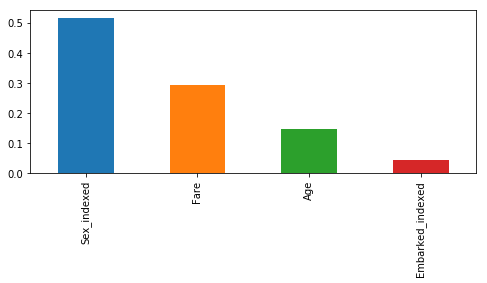

In [23]:
factory.computeFeatureImportances(pf, data).plot(kind="bar", figsize=(8,3))

In this example, the predictive model relies primarily on gender, ticket price, and age - and less so on the port where the passenger embarked. Interpreting this result can suggest several hypotheses, for example that passengers and crew followed the rule of "women and children first", that the lower class passengers had a lower chance of survival..  

Interpreting feature importances in a rigorous way is not trivial and merits more discussion. However, a plot like this is a good starting point for **exploratory analysis**.